# 对抗样本生成  

## 威胁模型  
对抗攻击方法有很多，他们有各式各样的攻击目标，攻击者对于被攻击模型能了解到的信息也不尽相同。  一般来说，攻击的基本套路是对输入数据添加最小程度的扰动，从而导致攻击者期望的错误分类。   

鉴于攻击者已知的信息，攻击方法可以大致分为两类：**白盒攻击**和**黑盒攻击**。
*白盒攻击*假定攻击者完全了解并且可以访问模型，包括其体系结构、输入、输出和权重。黑盒攻击则假定攻击者只能访问模型的输入和输出，而对底层架构或权重一无所知。  

攻击目标也不止一种，包括**错误分类**以及**源/目标错误分类**。*错误分类*的目标意味着攻击者只希望模型的输出分类是错误的，而不在乎具体的输出分类是什么。*源/目标错误分类*意味着攻击者希望改变对于特定输入，模型输出为指定的类别。

在本次试验中，FGSM 攻击是一种白盒攻击，目的是使模型错误分类。有了这些背景信息，我们现在可以讨论攻击的细节了。

## 快速梯度符号攻击（FGSM）  

最早流行的对抗性攻击之一就是快速梯度符号攻击(FGSM)，由 Goodfellow 等人在 [*Explaining and Harnessing Adversarial Examples*](https://arxiv.org/abs/1412.6572) 提出。这种攻击方法非常有效且直观。它通过利用神经网络的学习方式——梯度来攻击神经网络。想法很简单，不通过调整基于后向传播梯度的权重来减少损失，而是基于相同的后向传播梯度**调整输入数据来最大化损失**。换句话说，攻击利用损失的梯度修正输入数据，然后调整输入数据以使损失最大化。  

在我们开始码代码之前，先让我们看看著名的 FGSM 熊猫示例并说明一下用到的符号。  

![1-1](https://i.loli.net/2021/02/08/Vld4OgqeabvRNHs.png)  
如上图所示，$x$ 是可以正确分类为“熊猫”的原始输入图像，$y$ 是 $x$ 的正确分类标签，$\theta$ 代表模型的参数，$J(\theta,x,y)$ 是用来模型的损失，攻击将梯度反向传播到输入数据中并计算$\nabla xJ(\theta,x,y)$。然后，将输入数据朝着一个方向（如：$sign(\nabla xJ(\theta,x,y)$）调整一小步（$\epsilon$ 或如上图中的 $0.007$）来最大化模型的损失。得到扰动的图像 $x'$，使得明明看起来是“熊猫”的图像分类结果变成“长臂猿”。  

下面开始动手实现代码。

In [2]:
from __future__ import print_function
from typing import Any
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets,transforms
import numpy as np
import matplotlib.pyplot as plt

## 实现

在本节中，我们将讨论教程的输入参数，定义受到攻击的模型，然后编写攻击代码并做一些测试。

### 输入
本教程只有三个输入，定义如下:
- epsilons：运行时使用的 $\epsilon$ 的列表。在列表中保留 0 非常重要，因为它表示原始测试集上的模型性能。而且，我们直观地认为 $\epsilon$ 值越大，扰动越明显，分类模型准的确度降低得也越明显。因为数据的值在$[0,1]$，所以 $\epsilon$ 不能超过 1。
- pretrained_model：通过 [pytorch/examples/MNIST](https://github.com/pytorch/examples/tree/master/mnist) 训练的 MNIST 模型。为了简单起见，下载[预训练模型](https://drive.google.com/drive/folders/1fn83DF14tWmit0RTKWRhPq5uVXt73e0h?usp=sharing)。
- use_cuda：如果有可用的 CUDA，此布尔值为 True。注意，GPU 和 CUDA 并不是本教程的关键，用 CPU 也用不了多少时间。

In [3]:
epsilons = [0, .05, .1, .15, .2, .25, .3]
pretrained_model = "data/lenet_mnist_model.pth"
use_cuda = True

### 攻击模型
上文提到，用来攻击的模型是来自 [pytorch/examples/mnist](https://github.com/pytorch/examples/tree/master/mnist) 的MNIST。你可以训练自己的 MNIST 模型，也可以下载预训练模型。我们定义的 *Net* 类和测试数据都是从 MNIST 样例复制来的。这部分内容目的是定义模型和数据加载器，然后初始化模型并载入预训练权重。

In [4]:
# 定义 LeNet 模型
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

# 声明 MNIST 测试数据集和数据加载器
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=True, download=True,transform=transforms.Compose([
        transforms.ToTensor(),
    ])),
    batch_size=1, shuffle=True)

# 定义使用的硬件设备
print("是否支持CUDA: ", torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

# 初始化网络
model = Net().to(device)

# 载入预训练模型
model.load_state_dict(torch.load(pretrained_model, map_location='cpu'))

# 把模型设置为评估模式，在这里是因为有 Dropout 层
model.eval()

是否支持CUDA:  True


Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

### FGSM 攻击

现在，我们可以通过扰动原始输入来定义生成对抗样本的函数。`fgsm_attack` 函数有三个参数：*image* 是原始图像（$x$），*epsilon* 是像素级的扰动量（$\epsilon$），*data_grad* 是关于输入图像的损失的梯度（$\nabla xJ(\theta,x,y)$）。
函数生成扰动图像的原理如下：

$$扰动图像=image+epsilon∗sign(data\_grad)=x+ \epsilon ∗sign(\nabla xJ(\theta,x,y))$$

最后，为了保持数据的原始范围，将扰动图像剪切到$[0,1]$内。

In [5]:
# FGSM 攻击代码
def fgsm_attack(image, epsilon, data_grad):
    # 获取数据梯度的符号
    sign_data_grad = data_grad.sign()

    # 通过调整输入图像的每个像素来创建扰动图像
    perturbed_image = image + epsilon * sign_data_grad

    # 添加剪切操作来保证在[0,1]范围内
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image

### 测试函数

最后，本教程的主要结果来自 `test` 函数。此测试函数的每次调用都对 MNIST 测试集执行一个完整的测试流程，并返回最终的准确度。注意这个函数还需要输入一个参数 *epsilon*，这是因为 `test` 函数返回的是模型的准确度，这个模型受到的对抗攻击强度为 $\epsilon$ 。

更确切地说，对于测试集中的每个样本，该函数计算关于输入数据（data_graddata_grad）损失的梯度，通过 `fgsm_attack` 创建一个带有的受扰动的图像（perturbed_data），然后检查包含扰动的样本是否具有对抗性。

除了测试模型的准确性之外，该函数还保存并返回一些成功的对抗性示例，以供后面进行可视化。

In [6]:
def test(model, device, test_loader, epsilon):
    # 统计准确度
    correct = 0
    adv_examples = []
    for data, target in test_loader:

        # 把数据和标签存入指定设备
        data, target = data.to(device), target.to(device)

        # 设置张量的 requires_grad 属性，对于攻击至关重要
        data.requires_grad = True

        # 向前传播
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1]  # 获取对数概率最大的索引

        # 如果预测不准，不用管，继续
        if init_pred.item() != target.item():
            continue

        # 计算损失
        loss = F.nll_loss(output, target)

        # 清除所有已有梯度
        model.zero_grad()

        # 计算反向传播过程中的梯度
        loss.backward()

        # 保存数据的梯度
        data_grad = data.grad.data

        # 调用 FGSM 攻击
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        # 分类扰动图像
        output = model(perturbed_data)

        # 检查攻击是否成功
        final_pred = output.max(1, keepdim=True)[1]
        if final_pred.item() == target.item():
            correct += 1
            # epsilon 为 0 时的特例
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                # out是device：CUDA得到的 CUDA 张量
                # detach() 将张量脱离计算图，不再计算梯度
                # 如果想把 CUDA 张量的数据改成 numpy 时，需要先将其转换成 cpu float-tensor 随后再转到 numpy格式。
                # numpy不能读取 CUDA 张量，因此需要将它转化为 CPU 张量

                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex))
        else:
            # 保存一些对抗样本示例以便可视化
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex))
    # 计算在这个 epsilon 下最终的精度
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\t测试准确度 = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))
    return final_acc, adv_examples

### 开始攻击

最后一部分是实际运行攻击。我们为 *epsilons* 输入的每个 $\epsilon$ 值运行一次完整的测试步骤。对于每一个 $\epsilon$，我们还保存了最终的准确度以及一些成功的对抗样本示例，以便在接下来的章节中绘制图像。注意精确度是如何随着 $\epsilon$ 的增加而减少的。另外，请注意 $\epsilon=0$ 时表示原始数据的测试精度，此时并没有没有攻击。

In [7]:
accuracies = []
examples = []

# 为每个 ϵ 都测试一遍
for ep in epsilons:
    acc, ex = test(model, device, test_loader, ep)
    accuracies.append(acc)
    examples.append(ex)

Epsilon: 0	测试准确度 = 58869 / 60000 = 0.98115
Epsilon: 0.05	测试准确度 = 56355 / 60000 = 0.93925
Epsilon: 0.1	测试准确度 = 50856 / 60000 = 0.8476
Epsilon: 0.15	测试准确度 = 40515 / 60000 = 0.67525
Epsilon: 0.2	测试准确度 = 25274 / 60000 = 0.42123333333333335
Epsilon: 0.25	测试准确度 = 11698 / 60000 = 0.19496666666666668
Epsilon: 0.3	测试准确度 = 4684 / 60000 = 0.07806666666666667


### 结果

#### $\epsilon$ 跟准确度的关系
图一是精确度与 $\epsilon$ 的关系。正如前面提到的，随着 $\epsilon$ 的增加，我们预计测试的准确性会降低。这是因为较大的 $\epsilon$ 意味着我们在将损失最大化的方向上迈近了一步。
注意曲线中的趋势不是线性的，即使 $\epsilon$ 值是线性间隔的。例如， $\epsilon$ = 0.05 时的精度只比 $\epsilon$ = 0 时低 4% 左右，但是 $\epsilon$ = 0.2 时的精度比 $\epsilon$ = 0.15 时的精度低 25%。

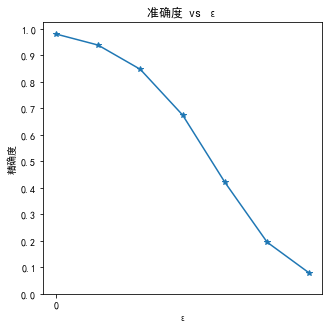

In [9]:
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, 0.35, step=0.5))
plt.title(u"准确度 vs \u03B5")
plt.xlabel(u"\u03B5")
plt.ylabel("精确度")
plt.show()

### 对抗样本示例

还记得没有免费的午餐这个概念吗？在这种情况下，随着 $\epsilon$ 的增加，测试准确度逐渐下降，而且添加的扰动也变得更容易察觉。在现实中，攻击者必须在准确度和感知力之间权衡。在这里，我们展示一些在每个 $\epsilon$ 下成功的对抗样本。图中的每一行都显示了不同的 $\epsilon$ 值。第一行是 $\epsilon =0$ 时候的例子，它表示没有任何干扰的原始“干净”图像。每张图片的标题格式都是“原始分类—>对抗样本分类”。注意，当 $\epsilon =0.15$ 时扰动开始变得明显，当 $\epsilon =0.3$ 时扰动变得相当明显。然而，在所有情况下，即使添加了噪声，人类仍然能够正确分类图像。

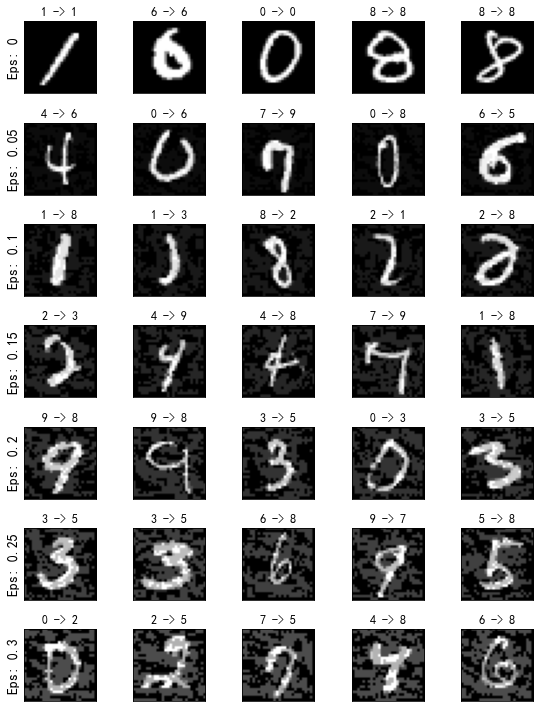

In [15]:
# 为每个 ϵ 展示几个对抗样本图像
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons), len(examples[0]), cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()

## 进一步发展
事实上，在2017年的 NIPS 比赛中，有一场对抗性的进攻和防守竞赛， [ Adversarial Attacks and Defences Competition](https://arxiv.org/pdf/1804.00097.pdf) 一文介绍了在比赛中使用的许多方法。防御方面的工作自然引出了关于使机器学习模型新的的想法——无论是面对自然的干扰还是对于精心设计的对抗性输入都更具鲁棒性。

另一个发展方向是在不同领域进行对抗性攻击和防御。对抗性研究并不局限于图像领域，看看[这个](https://arxiv.org/pdf/1801.01944.pdf)对语音到文本模型的攻击。学习更多对抗性机器学习的最好方法就是亲自动手实践。尝试 NIPS 2017 竞赛中不同的的攻击方法，看看它与 FGSM 有什么区别，然后试着保护模型免受你的攻击。